<a href="https://colab.research.google.com/github/Snigdho64/Google_Collab_Notebooks/blob/main/Project_2_NLP_SkimLit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project Overview
In this model we're going to replicat the deep learning model behind the 2017 paper [*PubMed 200k RCT : A Dataset for Sequential Sentence Classification*]('https://arxiv.org/abs/1710.06071').

When it was released, the paper presented a new dataset called `PubMed 200k RCT` which consists of ~ 200,000 labelled Randomized Controlled Trial (RCT).

The Goal of the the dataset was to explore the ability for NLP models to classify sentences which appear in sequential order.

Given an **Abstract** of a RCT, what role does each sentence serve in the abstract ?

<img src='https://camo.githubusercontent.com/685822b9841f09bb871773abdc10c66c3792beb1ec363fb1327c5e90aa695130/68747470733a2f2f7261772e67697468756275736572636f6e74656e742e636f6d2f6d7264626f75726b652f74656e736f72666c6f772d646565702d6c6561726e696e672f6d61696e2f696d616765732f30392d736b696d6c69742d6f766572766965772d696e7075742d616e642d6f75747075742e706e67'/>

*Our Deep Learning Model will Take an abstract wall of text and predict the section label each sentence should have*

###Goal : To label each line of an abstract paper into a categroy label based on the information the provide

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from os.path import join
from os import getcwd,listdir

#1. Getting the daat ready
Data is available at github - https://github.com/Franck-Dernoncourt/pubmed-rct.git

1. Clone the repo
2. Inspect the data
3. Select the 10_percent dataset folder
4. Read the Files
5. Check the Pattern

In [ ]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 0), reused 0 (delta 0), pack-reused 30
Unpacking objects: 100% (33/33), done.


In [ ]:
root_dir_name = 'pubmed-rct'
root_dir_path = join(getcwd(),root_dir_name)

In [ ]:
list(filter(lambda x:x.startswith('PubMed'),listdir(root_dir_path)))

['PubMed_200k_RCT',
 'PubMed_200k_RCT_numbers_replaced_with_at_sign',
 'PubMed_20k_RCT_numbers_replaced_with_at_sign',
 'PubMed_20k_RCT']

In [ ]:
dir_name = 'PubMed_20k_RCT_numbers_replaced_with_at_sign'
dir_path = join(root_dir_path,dir_name)
filenames = listdir(dir_path)
filenames

['train.txt', 'dev.txt', 'test.txt']

In [ ]:
def read_file(filename):
  '''
  Reads a text file and return the line sof the Text as Output
  Args:
  filename :(String) the target filename to read
  Returns:
  A list of string with one string per line
  '''
  with open(filename,'r') as f:
    text = f.readlines()
  return text

In [ ]:
read_file(join(dir_path,'train.txt'))[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

## Format and Restructure The Data For pre-processing
Formating Structure of our data :-

Each abstract starts with : **###[identification_number]**

The Labels are : **[BACKGROUND, OBJECTIVE, METHODS, RESULTS, CONCLUSION]**

At the end of each abstract there is an **emptyspace**


Re-structuring Procedure :-
We'll create a list of dictonaries for each abstract containing the following key/value pairs :

* `line_number` : The order/position of the line in the abstract
* `target` : the role of the line/label
* `text` : the text line in the abstact 
*`total_lines` : total number of lines in an abstract

In [ ]:
def structure_data(filename):
  '''
  Formats and re-structures the text of abstract papers into a list of dictionaries

  Args:
    filename : (string) target file path for the text of abstract papers
  Returns:
    A list of dictionaries per abstract from our text of abstract papers
    keys of the dictionary are :
      'line_number' : order of the line in the abstract
      'target' : label for each line based on the role
      'text' : test line from the abstract
      'total_lines' : total no of lines in the abstract
  '''
  text_lines = read_file(filename) #Get all lines from the abstract
  abstract_list = []

  #loop through each line in the text_lines:
  for line in text_lines:
    if line.startswith('###'):
      abstract_id = line[3:-1]
      order = -1
      abstract_dict = {}
      abstract_lines = []
    elif line.isspace():
      abstract_list.append(abstract_dict)
    else:
      order+=1
      target, text = tuple(line.split('\t'))
      abstract_line_dict = {
          'text':text[:-1],
          'target':target,
          'order':order
      }
      abstract_lines.append(abstract_line_dict)
      abstract_dict['id'] = abstract_id
      abstract_dict['lines'] = abstract_lines
      abstract_dict['total_lines'] = order+1
  return abstract_list

In [ ]:
train_list = structure_data(join(dir_path,'train.txt'))
valid_list = structure_data(join(dir_path,'dev.txt'))
test_list = structure_data(join(dir_path,'test.txt'))

In [ ]:
def map_abstract(abstract_list):
  mapped_list = []
  for abstract in abstract_list:
    for line in abstract['lines']:
      abstract_dict = {}
      abstract_dict['order'] = line['order']
      abstract_dict['text'] = line['text']
      abstract_dict['target'] = line['target']
      abstract_dict['total_lines'] = abstract['total_lines']

      mapped_list.append(abstract_dict)
    
  return mapped_list


In [ ]:
train_df = pd.DataFrame(map_abstract(train_list))
valid_df = pd.DataFrame(map_abstract(valid_list))
test_df = pd.DataFrame(map_abstract(test_list))

In [ ]:
len(train_df),len(valid_df),len(test_df)

(180040, 30212, 30135)

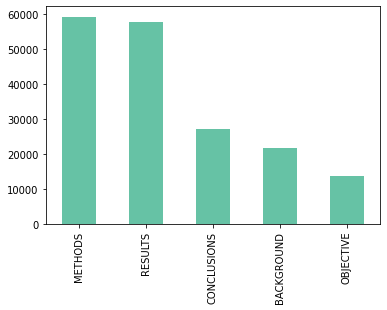

In [ ]:
train_df.target.value_counts().plot(kind='bar',cmap='Set2');

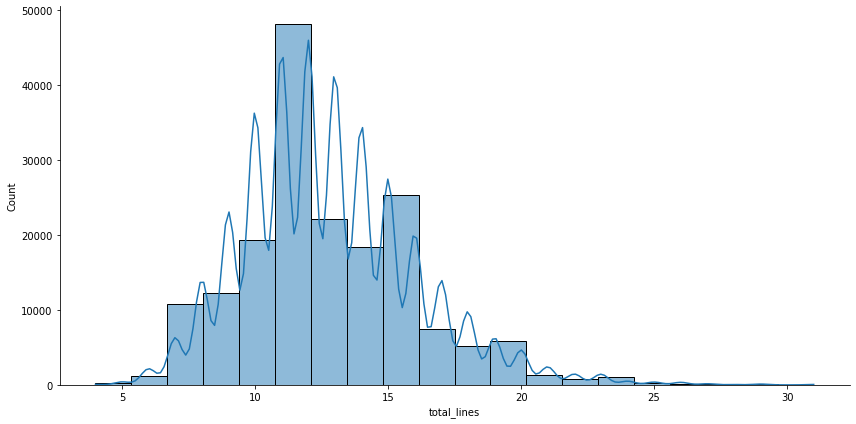

In [ ]:
sns.displot(data=train_df.total_lines,kind='hist',aspect=2,height=6,kde=True,bins=20,palette='Dark2')

#Creating our feature matrix (X) and labels (y) for our datasets

In [ ]:
X_train = train_df['text'].to_numpy()
X_valid = valid_df['text'].to_numpy()
X_test = test_df['text'].to_numpy()

X_train[:5]

array(['To investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .',
       'A total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
       'Outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
       'Pain was assessed using the visual analog pain scale ( @-@ mm ) .',
       'Secondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .'],
      dtype=object)

## Label encoding
Convert The label to Numeric Data
To encode the labels we'll use `sklearn`'s `OneHotEncoder` and `LabelEncoder` classes

In [ ]:
from sklearn.preprocessing import OneHotEncoder,LabelEncoder

In [ ]:
one_hot = OneHotEncoder(sparse=False)
y_train_one_hot = one_hot.fit_transform(np.array(train_df['target']).reshape(-1, 1))
y_valid_one_hot = one_hot.transform(np.array(valid_df['target']).reshape(-1, 1))
y_test_one_hot = one_hot.transform(np.array(test_df['target']).reshape(-1, 1))

In [ ]:
y_train_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [ ]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(train_df['target'].to_numpy())
y_valid_encoded = label_encoder.transform(valid_df['target'].to_numpy())
y_test_encoded = label_encoder.transform(test_df['target'].to_numpy())

In [ ]:
y_train_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [ ]:
class_names = label_encoder.classes_
class_names

array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
      dtype=object)

# Creating A Series Of Deep Learning Experiments
We have preprocessed our data, encoded our labels and created our Feature Matrix
Now, we'll perform experiments and create our models and then fine-tune our best model

## Model_0 : Baseline
We'll use **Naive-Bayes** `MultinomialNB` model from `sklearn`

For text_vectorization we'll use `TfidfVectorizer` from sklearn.feature_extraction module
tf-idf - term frequency - inverse document frequency

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

In [ ]:
#Create model Pipeline
model_0 = Pipeline([
                    ('tfidf',TfidfVectorizer()),
                    ('clf',MultinomialNB())
])

In [ ]:
#fit on the train data
model_0.fit(X_train,y_train_encoded)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [ ]:
from sklearn.metrics import accuracy_score,precision_recall_fscore_support
def evaluate(y_true,y_pred):
  '''
  Returns a dictionary on Evaluation Score on Various Metrics

  Args:
    y_true : (list/array) true_labels
    y_pred : (list/array) respective pred_labels
  '''
  acc = accuracy_score(y_true,y_pred)
  prec , recall, f1, _ = precision_recall_fscore_support(y_true,y_pred,average='weighted')

  return {
      'accuracy':acc,
      'precison': prec,
      'recall': recall,
      'f1': f1
  }

In [ ]:
y_pred_0 = model_0.predict(X_valid)
y_pred_0,len(y_pred_0)

(array([4, 1, 3, ..., 4, 4, 1]), 30212)

In [ ]:
y_valid_encoded,len(y_valid_encoded)

(array([0, 0, 3, ..., 4, 1, 1]), 30212)

In [ ]:
baseline_results = evaluate(y_valid_encoded,y_pred_0)
baseline_results

{'accuracy': 0.7218323844829869,
 'f1': 0.6989250353450294,
 'precison': 0.7186466952323352,
 'recall': 0.7218323844829869}

# Creating Tensorflow Datasets for our Tensorflow deep learning model

In [ ]:
word_counts = [len(x.split()) for x in X_train]
max_length = max(word_counts)
min_length = min(word_counts)
min_length, max_length

(1, 296)

In [ ]:
std_dev = np.std(word_counts).round(2)
mean = np.mean(word_counts).round(2)
std_dev, mean

(15.39, 26.34)

In [ ]:
# #Normalizing Values (Optional)
# normalized_wc = [(x - mean)/std_dev for x in word_counts]
# normalized_wc

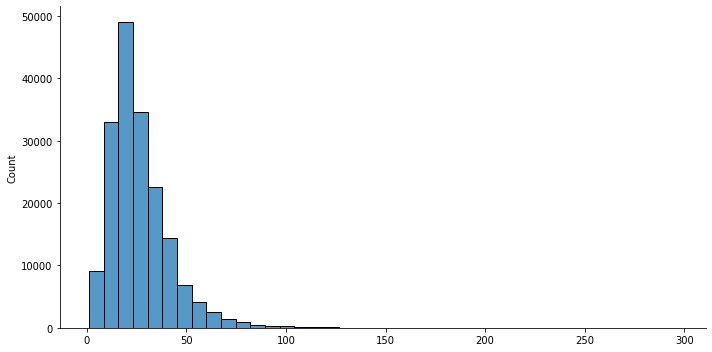

In [ ]:
sns.displot(kind='hist',bins=40,data=word_counts,aspect=2,)

In [ ]:
#What is the value for 95% of our word_counts
percent_95_value = np.percentile(word_counts,95).astype(int)
percent_95_value

55

## Tokenization and Embedding
For Tokenization we'll create as `TextVetorization` layer (map each word to a numeric_value)

For embedding we'll create a `Embedding` layer that creates **n** feature columns for each tokenized word

### Tokenization

In [ ]:
from tensorflow.keras.layers import TextVectorization

In [ ]:
max_tokens = 68000
output_seq_length = 55

In [ ]:
#create a text vetorization layer
text_vectorizer = TextVectorization(max_tokens=max_tokens,
                                    output_sequence_length=output_seq_length,
                                    name='text_vectorizer')

In [ ]:
#adapt text vectorizer to training sentences
text_vectorizer.adapt(X_train)

In [ ]:
text_vectorizer.get_config()

{'batch_input_shape': (None,),
 'dtype': 'string',
 'idf_weights': None,
 'max_tokens': 68000,
 'name': 'text_vectorizer',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'ragged': False,
 'sparse': False,
 'split': 'whitespace',
 'standardize': 'lower_and_strip_punctuation',
 'trainable': True,
 'vocabulary': None}

In [ ]:
rct_20k_vocab = text_vectorizer.get_vocabulary()
len(rct_20k_vocab)

64841

In [ ]:
rct_20k_vocab[:5],rct_20k_vocab[-5:]

(['', '[UNK]', 'the', 'and', 'of'],
 ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp'])

### Embedding Layer

In [ ]:
from tensorflow.keras.layers import Embedding

In [ ]:
embedding_layer = Embedding(input_dim=len(rct_20k_vocab),
                            output_dim=128,
                            mask_zero=True,
                            name='token_embeding')

In [ ]:
embedding_layer(text_vectorizer('http://www.clinicaltrials.gov .'))

<tf.Tensor: shape=(55, 128), dtype=float32, numpy=
array([[ 0.04846713,  0.00470067, -0.02268248, ..., -0.00886225,
        -0.02665625,  0.03675624],
       [ 0.04933797,  0.0113845 ,  0.01327604, ..., -0.01525088,
         0.00911081,  0.01648683],
       [ 0.04933797,  0.0113845 ,  0.01327604, ..., -0.01525088,
         0.00911081,  0.01648683],
       ...,
       [ 0.04933797,  0.0113845 ,  0.01327604, ..., -0.01525088,
         0.00911081,  0.01648683],
       [ 0.04933797,  0.0113845 ,  0.01327604, ..., -0.01525088,
         0.00911081,  0.01648683],
       [ 0.04933797,  0.0113845 ,  0.01327604, ..., -0.01525088,
         0.00911081,  0.01648683]], dtype=float32)>

## Creating Datsets From Tensor Slices
To ensure faster compuataion and load and process data from GPU

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train,y_train_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((X_valid,y_valid_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test,y_test_one_hot))

In [ ]:
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

## Model_1 : Conv1D Model

In [ ]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Input,GlobalAveragePooling1D,Conv1D,Dense

In [ ]:
#Build The Model
inputs = Input(shape=(1,),dtype='string')
x = text_vectorizer(inputs)
x = embedding_layer(x)
x = Conv1D(64,5,padding='same',activation='relu')(x)
x = GlobalAveragePooling1D()(x)
outputs = Dense(len(class_names),activation='softmax')(x)

model_1 = Model(inputs,outputs)

In [ ]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorizer (TextVector  (None, 55)               0         
 ization)                                                        
                                                                 
 token_embeding (Embedding)  (None, 55, 128)           8299648   
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 5)                 325   

In [ ]:
#Compile The Model
model_1.compile('adam','categorical_crossentropy',['accuracy'])

In [ ]:
def tensorboard_cb(dir_name='logs',experiment_name=None):
  '''
  Creates TensorBoard Callback in path /[dir_name]/[experiment_name]
  Returns Callback
  '''
  from os import getcwd
  from os.path import join,split
  from datetime import datetime
  from tensorflow.keras import callbacks
  log_dir = join(getcwd(),dir_name,experiment_name,datetime.now().strftime("%Y%m%d-%H%M%S"))
  print('Saving TensorBoard log files to:',log_dir)
  tb_cb = callbacks.TensorBoard(log_dir=log_dir) 
  return tb_cb

In [ ]:
histroy_1 = model_1.fit(train_dataset,
                        epochs=3,
                        steps_per_epoch=int(0.1*len(train_dataset)),
                        validation_data = valid_dataset,
                        validation_steps = int(0.1*len(valid_dataset)),
                        callbacks = [tensorboard_cb('logs','model_1')]
                        )

Saving TensorBoard log files to: /content/logs/model_1/20220128-054413
Epoch 1/3
562/562 [==============================] - 16s 9ms/step - loss: 0.9095 - accuracy: 0.6421 - val_loss: 0.6825 - val_accuracy: 0.7400
Epoch 2/3
562/562 [==============================] - 5s 9ms/step - loss: 0.6573 - accuracy: 0.7580 - val_loss: 0.6278 - val_accuracy: 0.7733
Epoch 3/3
562/562 [==============================] - 5s 9ms/step - loss: 0.6181 - accuracy: 0.7735 - val_loss: 0.5955 - val_accuracy: 0.7832


In [ ]:
y_pred_1 = model_1.predict(valid_dataset)
y_pred_1

array([[4.1875425e-01, 1.8750419e-01, 8.5194923e-02, 2.7276108e-01,
        3.5785537e-02],
       [4.6869546e-01, 2.5103265e-01, 1.5867416e-02, 2.5626743e-01,
        8.1370892e-03],
       [1.1463287e-01, 6.1766440e-03, 1.3764224e-03, 8.7776852e-01,
        4.5508161e-05],
       ...,
       [2.7852050e-06, 4.6747303e-04, 4.9378193e-04, 1.5090609e-06,
        9.9903452e-01],
       [5.9893474e-02, 4.6015605e-01, 1.0960206e-01, 6.9039851e-02,
        3.0130854e-01],
       [1.7284784e-01, 6.8157822e-01, 3.6557864e-02, 4.2237505e-02,
        6.6778556e-02]], dtype=float32)

In [ ]:
y_pred_1 = tf.argmax(y_pred_1,axis=1)
y_pred_1

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [ ]:
model_1_results = evaluate(y_valid_encoded,y_pred_1)
model_1_results

{'accuracy': 0.7865417714815305,
 'f1': 0.7839579311134398,
 'precison': 0.7828393631891928,
 'recall': 0.7865417714815305}

## Model_2 : Feature Extraction with Pretrained Token Embedding Layer

***Neural Networks For Joint Sentence Classifications*** :-
https://arxiv.org/pdf/1612.05251.pdf

***GloVe : Global Vectorizer*** :-
https://nlp.stanford.edu/projects/glove/

<img src='https://camo.githubusercontent.com/5ce1d1627c46bb2913a6eab6642f02282bed99afb9b5efb0089ec304785a2b77/68747470733a2f2f7261772e67697468756275736572636f6e74656e742e636f6d2f6d7264626f75726b652f74656e736f72666c6f772d646565702d6c6561726e696e672f6d61696e2f696d616765732f30392d6d6f64656c2d74662d6875622d5553452d746f2d64656e73652d6c617965722e706e67'/>

For feature extraction we'll use **USE (Universal Sentence Encoder)** from our `tensorflow_hub`
USE takes a input sequence of string of text and outputs a 512 feature columns for each sequence

In [ ]:
import tensorflow_hub as hub

In [ ]:
USE_layer = hub.KerasLayer('https://tfhub.dev/google/universal-sentence-encoder/4',
                           trainable=False,
                           name='USE_layer')

In [ ]:
#Test The USE layer
text = np.random.choice(X_train)
print('Original Sentence :\t',text)
encoded_text = USE_layer([text])
print('\nAfter Encoding With USE :\t',encoded_text[0][:5])
print('Shape :\t',encoded_text.shape)

Original Sentence :	 @ patients had a successful cardioversion and @ of the study group remained in sinus rhythm at day @ .

After Encoding With USE :	 tf.Tensor([-0.05965352  0.03921873 -0.02572913  0.02492845  0.00964979], shape=(5,), dtype=float32)
Shape :	 (1, 512)


In [ ]:
#Create the model with USE embedding 
inputs  =Input(shape=[],dtype='string')
x = USE_layer(inputs)
x = Dense(128,activation='relu')(x)
x = Dense(32,activation='relu')(x)
outputs = Dense(len(class_names),activation='softmax')(x)

model_2 = Model(inputs,outputs,name='model_2_use')

In [ ]:
model_2.summary()

Model: "model_2_use"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 USE_layer (KerasLayer)      (None, 512)               256797824 
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 32)                4128      
                                                                 
 dense_3 (Dense)             (None, 5)                 165       
                                                                 
Total params: 256,867,781
Trainable params: 69,957
Non-trainable params: 256,797,824
_________________________________________________________________


In [ ]:
model_2.compile('adam','categorical_crossentropy',['accuracy'])

In [ ]:
history_2 = model_2.fit(train_dataset,
                        epochs=3,
                        steps_per_epoch=int(0.1*len(train_dataset)),
                        validation_data=valid_dataset,
                        validation_steps=int(0.1*len(valid_dataset)),
                        callbacks=[tensorboard_cb('logs','model_2_USE')])

Saving TensorBoard log files to: /content/logs/model_2_USE/20220128-054457
Epoch 1/3
562/562 [==============================] - 11s 15ms/step - loss: 0.9044 - accuracy: 0.6507 - val_loss: 0.7950 - val_accuracy: 0.6915
Epoch 2/3
562/562 [==============================] - 8s 14ms/step - loss: 0.7539 - accuracy: 0.7075 - val_loss: 0.7306 - val_accuracy: 0.7121
Epoch 3/3
562/562 [==============================] - 8s 14ms/step - loss: 0.7255 - accuracy: 0.7212 - val_loss: 0.7013 - val_accuracy: 0.7264


In [ ]:
y_pred_2 = model_2.predict(valid_dataset)
y_pred_2, y_pred_2.shape

(array([[5.1018620e-01, 2.7125272e-01, 2.4597363e-03, 2.1018259e-01,
         5.9187566e-03],
        [3.2845998e-01, 5.2580768e-01, 3.5417322e-03, 1.3988696e-01,
         2.3036823e-03],
        [2.1804388e-01, 4.3518402e-02, 1.8218327e-02, 6.9969046e-01,
         2.0528907e-02],
        ...,
        [1.4918650e-03, 3.4079717e-03, 3.6859822e-02, 6.6502183e-04,
         9.5757532e-01],
        [4.1257842e-03, 4.7421303e-02, 2.2921894e-01, 1.9709838e-03,
         7.1726298e-01],
        [2.3771915e-01, 4.4152203e-01, 2.8322214e-01, 9.9116359e-03,
         2.7625008e-02]], dtype=float32), (30212, 5))

In [ ]:
y_pred_2 = np.argmax(y_pred_2,axis=1)
y_pred_2

array([0, 1, 3, ..., 4, 4, 1])

In [ ]:
model_2_results = evaluate(y_valid_encoded,y_pred_2)
model_2_results

{'accuracy': 0.7285515689130146,
 'f1': 0.7273852082067485,
 'precison': 0.7292649254707514,
 'recall': 0.7285515689130146}

## Character-Level Embedding
For Each Character we'll create a token.
So,we'll have a token per character for each sequence
<img src='https://camo.githubusercontent.com/a8f036b4aae49b4038817b7ead978cf84dec304c7d1322e0575f9a16757f920f/68747470733a2f2f7261772e67697468756275736572636f6e74656e742e636f6d2f6d7264626f75726b652f74656e736f72666c6f772d646565702d6c6561726e696e672f6d61696e2f696d616765732f30392d746f6b656e2d76732d6368617261637465722d656d62656464696e67732e706e67' style="width':100vw;height:100vh"/>

### Creating Character-level tokenized Datasets

In [ ]:
#Fuction to split each word into characters
def split_text(text):
  return ' '.join(list(text))

In [ ]:
#Convert out text sequenced data into character-level sequenced data
X_train_char = [split_text(text) for text in X_train]
X_valid_char = [split_text(text) for text in X_valid]
X_test_char = [split_text(text) for text in X_test]

In [ ]:
#Lengths of charaters per sequence for each dataset
X_train_char_lengths = [len(x.split()) for x in X_train_char]
X_valid_char_lengths = [len(x.split()) for x in X_valid_char]
X_test_char_lengths = [len(x.split()) for x in X_test_char]

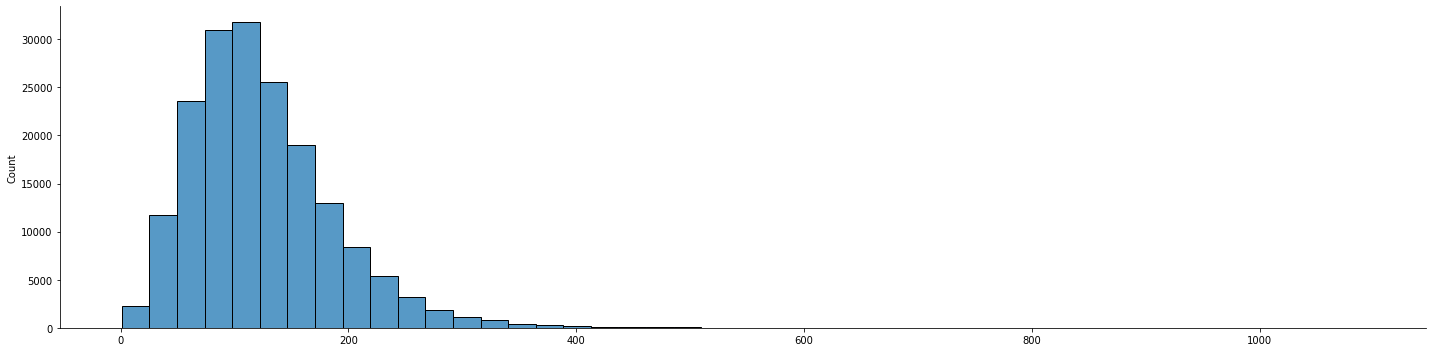

In [ ]:
#Check th Distribution of Character lengths for the training data
sns.displot(X_train_char_lengths,aspect=4,bins=45,palette='Dark2');

In [ ]:
#Charater Length for 95 percent of our train data
char_length_95_percent = int(np.percentile(X_train_char_lengths,95))
char_length_95_percent

239

In [ ]:
#Get the total characters length
import string
char_list = string.ascii_lowercase + string.digits + string.punctuation
max_char_tokens = len(char_list)

In [ ]:
#Create vetorizer layer for char-level embedding
char_vectorizer = TextVectorization(max_tokens=max_char_tokens,
                                    output_sequence_length=char_length_95_percent,
                                    standardize=None,
                                    name='char_vetorizer')

In [ ]:
#Adapted char_vectorizer to training instances
char_vectorizer.adapt(X_train_char)

In [ ]:
#Check Character Vocabulary
char_vocab = char_vectorizer.get_vocabulary()
print('Number of Different Characters :\t',len(char_vocab))
print('\Most common Characters :\t',char_vocab[:5])
print('Least Common Characters :\t',char_vocab[-5:])

Number of Different Characters :	 68
\Most common Characters :	 ['', '[UNK]', 'e', 't', 'i']
Least Common Characters :	 ['+', 'X', '`', '>', 'J']


### Char-Level embedding Layer

In [ ]:
#create the embedding layer for char-level embedding
char_embedding_layer = Embedding(input_dim=len(char_vocab),
                                 output_dim=25,
                                 mask_zero=False,
                                 name='char_embedding_layer')

In [ ]:
#Test the vectorizer layer and embedding
text = np.random.choice(X_train_char)
print(f'Text Before Vectorization :\n{text}')
text_vectorized = char_vectorizer([text])
print('\nText After Vectorization :\t',text_vectorized)
print('\nShape :\n',text_vectorized.shape)
text_embeded = char_embedding_layer(text_vectorized)
print('\nText After Embedding :\n',text_embeded)
print('\nShape :\t',text_embeded.shape)

Text Before Vectorization :
H y p o t e n s i o n   i n d u c e d   b y   p l a s m a   t a r g e t - c o n t r o l l e d   i n f u s i o n   o f   p r o p o f o l   c o u l d   m a i n l y   b e   a t t r i b u t e d   t o   d e c r e a s e d   s t r o k e   v o l u m e   i n s t e a d   o f   v a s c u l a r   d i l a t i o n   .

Text After Vectorization :	 tf.Tensor(
[[46 20 14  7  3  2  6  9  4  7  6  4  6 10 16 12  2 10 23 20 14 11  5  9
  15  5  3  5  8 18  2  3 26 12  7  6  3  8  7 11 11  2 10  4  6 17 16  9
   4  7  6  7 17 14  8  7 14  7 17  7 11 12  7 16 11 10 15  5  4  6 11 20
  23  2  5  3  3  8  4 23 16  3  2 10  3  7 10  2 12  8  2  5  9  2 10  9
   3  8  7 35  2 22  7 11 16 15  2  4  6  9  3  2  5 10  7 17 22  5  9 12
  16 11  5  8 10  4 11  5  3  4  7  6 25  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0

In [ ]:
#Create datasets for charater-level sequence
train_dataset_char = tf.data.Dataset.from_tensor_slices((X_train_char,y_train_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset_char = tf.data.Dataset.from_tensor_slices((X_valid_char,y_valid_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
train_dataset_char

<PrefetchDataset shapes: ((None,), (None, 5)), types: (tf.string, tf.float64)>

## Model_2 : Conv1D with Char-level embedding

In [ ]:
from tensorflow.keras.layers import GlobalMaxPooling1D

In [ ]:
#Conv1D Moel with char-level emedding
inputs = Input(shape=(1,),dtype='string')
x = char_vectorizer(inputs)
x = char_embedding_layer(x)
x = Conv1D(64,5,padding='same',activation='relu')(x)
x = GlobalMaxPooling1D()(x)
outputs = Dense(len(class_names),activation='softmax')(x)

model_3 = Model(inputs,outputs)

In [ ]:
#compile the model
model_3.compile('adam','categorical_crossentropy',['accuracy'])

In [ ]:
model_3.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vetorizer (TextVectori  (None, 239)              0         
 zation)                                                         
                                                                 
 char_embedding_layer (Embed  (None, 239, 25)          1700      
 ding)                                                           
                                                                 
 conv1d_1 (Conv1D)           (None, 239, 64)           8064      
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                           

In [ ]:
#fit the model
model_3_history = model_3.fit(train_dataset_char,
                              epochs=3,
                              steps_per_epoch=int(0.1*len(train_dataset_char)),
                              validation_data=valid_dataset_char,
                              validation_steps=int(0.1*len(valid_dataset_char)),
                              callbacks=[tensorboard_cb('logs','model_3_char')]
                              )

Saving TensorBoard log files to: /content/logs/model_3_char/20220128-054617
Epoch 1/3
562/562 [==============================] - 4s 6ms/step - loss: 1.1655 - accuracy: 0.5386 - val_loss: 0.9449 - val_accuracy: 0.6220
Epoch 2/3
562/562 [==============================] - 3s 6ms/step - loss: 0.9012 - accuracy: 0.6392 - val_loss: 0.8564 - val_accuracy: 0.6692
Epoch 3/3
562/562 [==============================] - 3s 6ms/step - loss: 0.8364 - accuracy: 0.6715 - val_loss: 0.7922 - val_accuracy: 0.6975


In [ ]:
y_pred_3 = model_3.predict(valid_dataset_char)
y_pred_3

array([[0.16457371, 0.47860405, 0.11581622, 0.19595523, 0.0450508 ],
       [0.27734062, 0.43881446, 0.01812147, 0.19190343, 0.07381996],
       [0.20127961, 0.40501454, 0.09146706, 0.20079173, 0.10144705],
       ...,
       [0.00505312, 0.00853909, 0.06871442, 0.00538753, 0.9123058 ],
       [0.01073295, 0.04312572, 0.42762265, 0.00552955, 0.51298916],
       [0.45136374, 0.4365727 , 0.03894185, 0.06923403, 0.00388768]],
      dtype=float32)

In [ ]:
y_pred_3 = tf.argmax(y_pred_3,axis=1)
y_pred_3

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 1, 1, ..., 4, 4, 0])>

In [ ]:
model_3_results = evaluate(y_valid_encoded,y_pred_3)
model_3_results

{'accuracy': 0.6905203230504435,
 'f1': 0.6802593894371501,
 'precison': 0.6890418903224584,
 'recall': 0.6905203230504435}

## Model_4 : Combining pretrained token embeddings + character embeddings (Hybrid Embedding Layer)
This hybrid token embedding layer is a combination of `token_embeddings` and `character_embeddings`. In other words, they create a stacked embedding to represent sequenes before passing them, to the sequence label prediction layer.

Steps :-
  1. Create a token-level model (similar to model_1)
  2. Create a character-level model (similar to model_3) with a slight modification to reflect the the paper.
  3. Combine (using `layers.Concatenate`) the outputs of model_1 and model_2
  4. Build a series of output layers on top of 3.
  5. Construct a model which takes token and character-level sequences as inputs and produces squence level probabilities as output.

In [ ]:
from tensorflow.keras.layers import Bidirectional, Dropout, LSTM, Concatenate

In [ ]:
#1. Set-up token inputs
token_inputs = Input(shape=[],dtype=tf.string,name='token_input')
token_embeddings = USE_layer(token_inputs)
token_dense = Dense(128,activation='relu')(token_embeddings)
token_model = Model(inputs=token_inputs,
                             outputs=token_dense)

#2. Set-up char-level inputs/model
char_inputs = Input(shape=(1,),dtype=tf.string,name='char_input')
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embedding_layer(char_vectors)
char_bi_lstm = Bidirectional(LSTM(25))(char_embeddings)
char_model = Model(inputs=char_inputs,
                    outputs=char_bi_lstm)

#3. Concatenate token and char inputs (create hybrid layers)
token_char_concat = Concatenate(name='token_char_hybrid')([token_model.output,
                                                           char_model.output])

#4. Create output layer sequences for the concatenated model
combined_dropout = Dropout(0.5)(token_char_concat)
combined_dense = Dense(200, activation='relu')(combined_dropout)
final_dropout = Dropout(0.5)(combined_dense)
output_layer = Dense(len(class_names), activation = 'softmax')(final_dropout)

#5. Construct model with char and token inputs
model_4 = Model(inputs=[token_model.input,char_model.input],
                outputs=output_layer,
                name='model_4_token_and_char_embeddings')

In [ ]:
model_4.summary()

Model: "model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 char_vetorizer (TextVectorizat  (None, 239)         0           ['char_input[0][0]']             
 ion)                                                                                             
                                                                                                  
 USE_layer (KerasLayer)         (None, 512)          256797824   [

In [ ]:
from tensorflow.keras.utils import plot_model

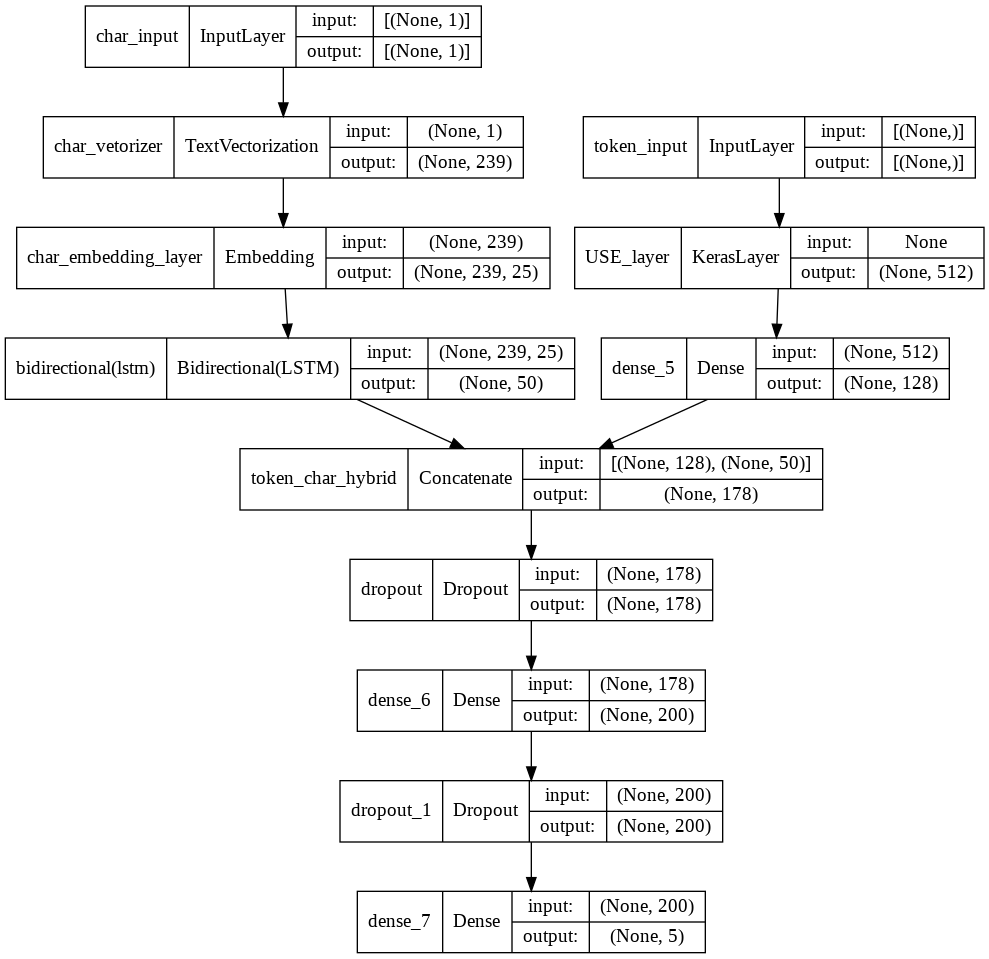

In [ ]:
plot_model(model_4,show_shapes=True)

In [ ]:
model_4.compile('adam',
                'categorical_crossentropy',
                ['accuracy'])

##Create our combined Dataset
We'll create our combined input dataset usin `tf.data.Dataset` for our hybrid model for faster loading

Combined char-level and word-level sequence dataset in order as required by model


In [ ]:
# Train char token data batch
X_train_char_token = tf.data.Dataset.from_tensor_slices((X_train,X_train_char))
y_train_char_token = tf.data.Dataset.from_tensor_slices(y_train_one_hot)
train_char_token_dataset = tf.data.Dataset.zip((X_train_char_token,y_train_char_token)).batch(32).prefetch(tf.data.AUTOTUNE)

# Valid char token data batch
X_valid_char_token = tf.data.Dataset.from_tensor_slices((X_valid,X_valid_char))
y_valid_char_token = tf.data.Dataset.from_tensor_slices(y_valid_one_hot)
valid_char_token_dataset = tf.data.Dataset.zip((X_valid_char_token,y_valid_char_token)).batch(32).prefetch(tf.data.AUTOTUNE)


In [ ]:
model_4_history = model_4.fit(train_char_token_dataset,
                              epochs=3,
                              steps_per_epoch=int(0.1*len(train_char_token_dataset)),
                              validation_data=valid_char_token_dataset,
                              validation_steps=int(0.1*len(valid_char_token_dataset)),
                              callbacks=[tensorboard_cb('logs','model_4_char_token')]
                              )

Saving TensorBoard log files to: /content/logs/model_4_char_token/20220128-054633
Epoch 1/3
562/562 [==============================] - 27s 38ms/step - loss: 0.9651 - accuracy: 0.6180 - val_loss: 0.7610 - val_accuracy: 0.7041
Epoch 2/3
562/562 [==============================] - 20s 36ms/step - loss: 0.7862 - accuracy: 0.6928 - val_loss: 0.7104 - val_accuracy: 0.7294
Epoch 3/3
562/562 [==============================] - 20s 36ms/step - loss: 0.7576 - accuracy: 0.7122 - val_loss: 0.6745 - val_accuracy: 0.7497


In [ ]:
y_pred_4 = model_4.predict(valid_char_token_dataset)
y_pred_4

array([[4.0248474e-01, 3.7330094e-01, 2.3654955e-03, 2.1618257e-01,
        5.6662662e-03],
       [3.7947714e-01, 4.7977409e-01, 2.0972362e-03, 1.3664848e-01,
        2.0031224e-03],
       [2.5736511e-01, 8.8058792e-02, 2.4107022e-02, 6.1008567e-01,
        2.0383380e-02],
       ...,
       [4.9358804e-04, 5.4746410e-03, 6.6856205e-02, 2.8778575e-04,
        9.2688781e-01],
       [2.3776088e-03, 2.1445023e-02, 2.1787904e-01, 1.4394230e-03,
        7.5685894e-01],
       [3.1189921e-01, 5.0707835e-01, 1.2556362e-01, 2.7230097e-02,
        2.8228670e-02]], dtype=float32)

In [ ]:
y_pred_4 = tf.argmax(y_pred_4,axis=1)
y_pred_4

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 1])>

In [ ]:
model_4_results = evaluate(y_valid_encoded,y_pred_4)
model_4_results

{'accuracy': 0.7450019859658414,
 'f1': 0.7430321791344888,
 'precison': 0.745853416596566,
 'recall': 0.7450019859658414}

# Model_5 : Transfer Learning + Feature Engineering
For our final model, we'll use a combination of **token_embeddings**, **char_embeddings** and **positional_embeddings**.
Our Dataset contains only text sequence of the abstract and there labels. We'll add additianal features -> **line_order** and **total_lines** (in a abstract) [Feature Engineering].
Then' we'll train our model based on the three input features ->
  1. Input Words in Text Sequence
  2. Input Charaters in Text Sequence
  3. Line Order of a Text in the abstract
  4. Total Lines in the abstract

We'll create separate models for each feature and later we'll combine (Concatenate) the models to create the final output layers

In [ ]:
train_df.head()

,order,text,target,total_lines
0,0,To investigate the efficacy of @ weeks of dail...,OBJECTIVE,12
1,1,A total of @ patients with primary knee OA wer...,METHODS,12
2,2,Outcome measures included pain reduction and i...,METHODS,12
3,3,Pain was assessed using the visual analog pain...,METHODS,12
4,4,Secondary outcome measures included the Wester...,METHODS,12


## one_hot encode the `line_order` and `total_lines`

In [ ]:
#Get the line_order and total_lines for the datasets
line_order_train = train_df['order'].to_numpy()
total_lines_train = train_df['total_lines'].to_numpy()

line_order_valid = valid_df['order'].to_numpy()
total_lines_valid = valid_df['total_lines'].to_numpy()

line_order_test = test_df['order'].to_numpy()
total_lines_test = test_df['total_lines'].to_numpy()


### one_hot_encode `line_order`

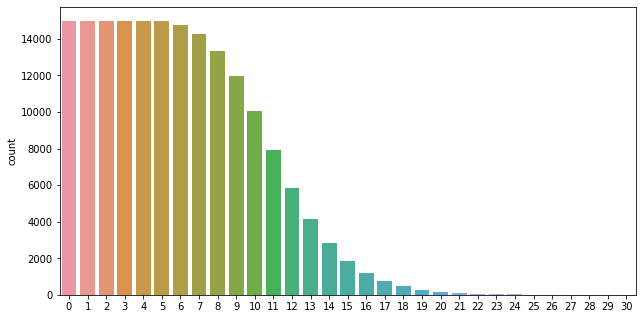

In [ ]:
#Check the `line_order` distribution
ax = plt.figure(figsize=(8,4)).add_axes([0,0,1,1])
sns.countplot(x=line_order_train,ax=ax);
# pd.Series(line_order_train).value_counts()

In [ ]:
# line_order for 95 percent of our train data
max_line_order_depth = int(np.percentile(line_order_train,99))
max_line_order_depth

17

In [ ]:
#one_hot encode line_order
line_order_one_hot_train = tf.one_hot(line_order_train,depth=max_line_order_depth)

line_order_one_hot_valid = tf.one_hot(line_order_valid,depth=max_line_order_depth)
line_order_one_hot_train

<tf.Tensor: shape=(180040, 17), dtype=float32, numpy=
array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>

### one_hot encode `total_lines`

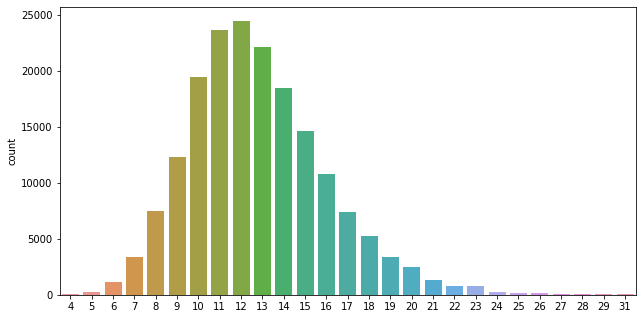

In [ ]:
#Check the `total_lines` distribution
ax = plt.figure(figsize=(8,4)).add_axes([0,0,1,1])
sns.countplot(x=total_lines_train,ax=ax);
# pd.Series(total_lines_train).value_counts()

In [ ]:
# total_lines for 95 percent of our train data
max_total_lines_depth = int(np.percentile(total_lines_train,99))
max_total_lines_depth

22

In [ ]:
#one_got encode total_lines
total_lines_one_hot_train = tf.one_hot(total_lines_train,depth=max_total_lines_depth)

total_lines_one_hot_valid = tf.one_hot(total_lines_valid,depth=max_total_lines_depth)
total_lines_one_hot_train

<tf.Tensor: shape=(180040, 22), dtype=float32, numpy=
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>

## Buid the Model Architecture
Steps:-
  1. Create a `token_level` model (model_1)
  2. Create a `char_level` model (model_2)
  3. Create a `line_order` model (model_3)
  4. Create a `total_lines` model (model_4)
  5. Concatenate all the models
    5.1 Concatenate outputs of `model_1` and `model_2` and add a `dropout` output layer for regularization (`token_char_output`)
    5.2 Concatenate outputs of `model_3` and `model_4` with the `token_char_layer` (`tribrid_model`)
  6. Add few output layers
  7. Add the final dense output layer of shape = num_of_classes that outputs the class_probabilities
  8. Create the model with the inputs for each 4 models respectively and the output of the tribrid model

In [ ]:
#token_level model
token_inputs = Input(shape=(),dtype='string',name='token_inputs')
x1 = USE_layer(token_inputs)
x1 = Dense(128,activation='relu')(x1)

#char_level model
char_inputs = Input(shape=(1,),dtype='string',name='char_inputs')
x2 = char_vectorizer(char_inputs)
x2 = char_embedding_layer(x2)
x2 = Bidirectional(LSTM(32))(x2)
x2 = Dense(128,activation='relu')(x2)

#Concatenate token_level and char_level
x1_and_x2 = Concatenate(name='char_token_concat')([x1,x2])
x1_and_x2 = Dense(256,activation='relu')(x1_and_x2)
char_token_layer = Dropout(0.5)(x1_and_x2)

#line_order model
line_order_inputs = Input(shape=line_order_one_hot_train[0].shape,name='line_order_inputs',dtype=tf.float32)
x3 = Dense(32,activation='relu')(line_order_inputs)

#total_lines model
total_lines_inputs = Input(shape=total_lines_one_hot_train[0].shape,name='total_lines_inputs',dtype=tf.float32)
x4 = Dense(32,activation='relu')(total_lines_inputs)

#Concatenate all the three layes
char_token_pos_layer = Concatenate(name='char_token_pos_tribrid')([char_token_layer,x3,x4])
z = Dense(128,activation='relu')(char_token_pos_layer)
z = Dropout(0.5)(z)
z = Dense(32,activation='relu')(z)
outputs = Dense(len(class_names),activation='softmax')(z)

#Create the Model
model_5 = Model(inputs=(token_inputs,char_inputs,line_order_inputs,total_lines_inputs),
                outputs=outputs)

In [ ]:
model_5.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_inputs (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 char_vetorizer (TextVectorizat  (None, 239)         0           ['char_inputs[0][0]']            
 ion)                                                                                             
                                                                                                  
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 char_embedding_layer (Embeddin  (None, 239, 25)     1700        ['char_vetorizer[2][0]']   

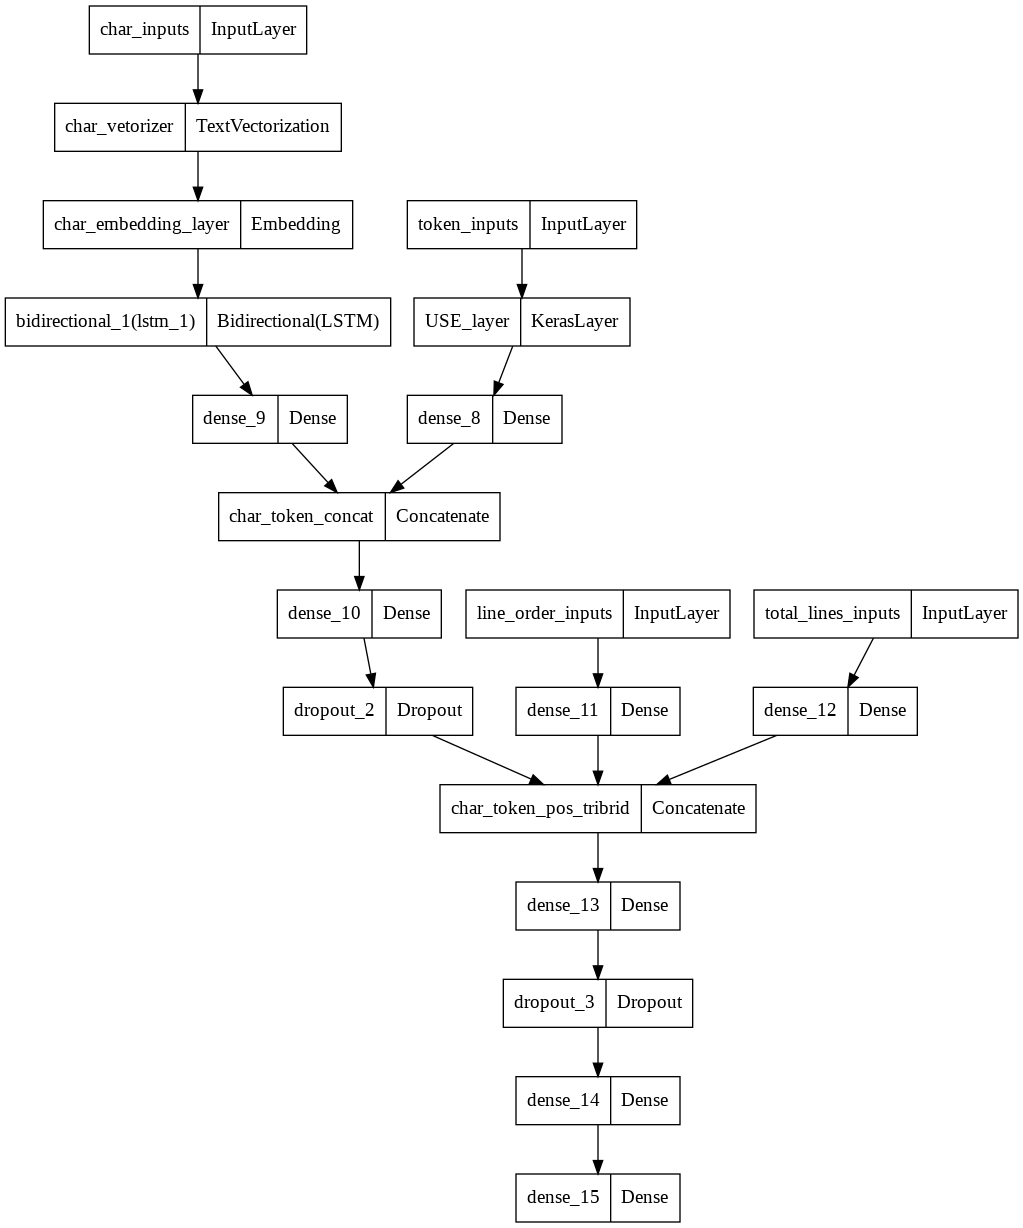

In [ ]:
plot_model(model_5)

## Create the Dataset as required by the model

In [ ]:
from tensorflow.data import Dataset,AUTOTUNE

In [ ]:
# For our train data
X_train = Dataset.from_tensor_slices((X_train,X_train_char,line_order_one_hot_train,total_lines_one_hot_train))
y_train = Dataset.from_tensor_slices(y_train_one_hot)
train_dataset = Dataset.zip((X_train,y_train)).batch(32).prefetch(AUTOTUNE)

# For our valid data
X_valid = Dataset.from_tensor_slices((X_valid,X_valid_char,line_order_one_hot_valid,total_lines_one_hot_valid))
y_valid = Dataset.from_tensor_slices(y_valid_one_hot)
valid_dataset = Dataset.zip((X_valid,y_valid)).batch(32).prefetch(AUTOTUNE)

In [ ]:
model_5.compile(optimizer=tf.keras.optimizers.Adam(),
                loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
                metrics=['accuracy'])

In [ ]:
model_5_history = model_5.fit(train_dataset,
                              epochs=5,
                              steps_per_epoch=int(0.1*len(train_dataset)),
                              validation_data=valid_dataset,
                              validation_steps=int(0.1*len(valid_dataset)),
                              callbacks=[tensorboard_cb('logs','model_5_char_token_pos')]
                              )

Saving TensorBoard log files to: /content/logs/model_5_char_token_pos/20220128-054821
Epoch 1/5
562/562 [==============================] - 27s 40ms/step - loss: 1.1062 - accuracy: 0.7094 - val_loss: 0.9492 - val_accuracy: 0.8158
Epoch 2/5
562/562 [==============================] - 20s 36ms/step - loss: 0.9572 - accuracy: 0.8160 - val_loss: 0.9150 - val_accuracy: 0.8351
Epoch 3/5
562/562 [==============================] - 21s 38ms/step - loss: 0.9300 - accuracy: 0.8325 - val_loss: 0.8905 - val_accuracy: 0.8534
Epoch 4/5
562/562 [==============================] - 20s 36ms/step - loss: 0.9187 - accuracy: 0.8426 - val_loss: 0.8869 - val_accuracy: 0.8514
Epoch 5/5
562/562 [==============================] - 20s 36ms/step - loss: 0.9143 - accuracy: 0.8448 - val_loss: 0.8823 - val_accuracy: 0.8564


In [ ]:
y_pred_5 = model_5.predict(valid_dataset)
y_pred_5 = tf.argmax(y_pred_5,axis=1)
y_pred_5

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [ ]:
model_5_results = evaluate(y_valid_encoded,y_pred_5)
model_5_results

{'accuracy': 0.8563484708063022,
 'f1': 0.8537533777517786,
 'precison': 0.8606899760406728,
 'recall': 0.8563484708063022}

In [ ]:
all_results_df = pd.DataFrame({'model_1':model_1_results,
                               'model_2':model_2_results,
                               'model_3':model_3_results,
                               'model_4':model_4_results,
                               'model_5':model_5_results
                               })
all_results_df = all_results_df.T
all_results_df

,accuracy,precison,recall,f1
model_1,0.786542,0.782839,0.786542,0.783958
model_2,0.728552,0.729265,0.728552,0.727385
model_3,0.690520,0.689042,0.690520,0.680259
model_4,0.745002,0.745853,0.745002,0.743032
model_5,0.856348,0.860690,0.856348,0.853753


<Figure size 576x288 with 0 Axes>

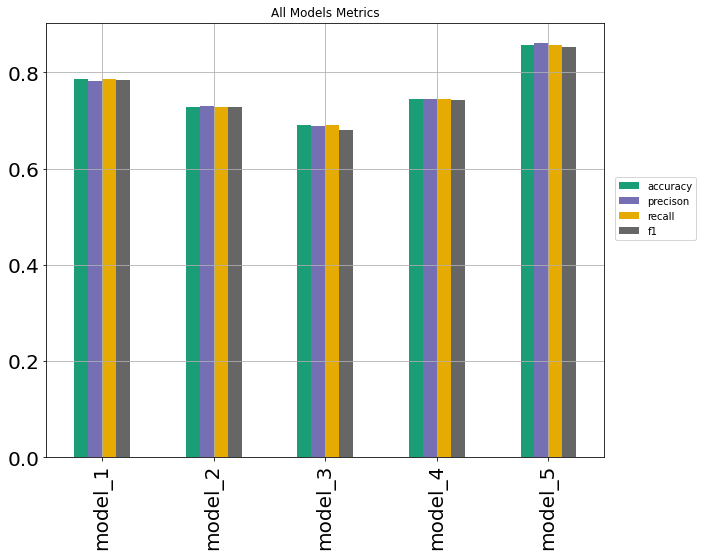

In [ ]:
plt.figure(figsize=(8,4))
all_results_df.plot(kind='bar',figsize=(10,8),title='All Models Metrics',fontsize=20,cmap='Dark2');
plt.legend(loc=(1.02,0.5))
plt.grid();

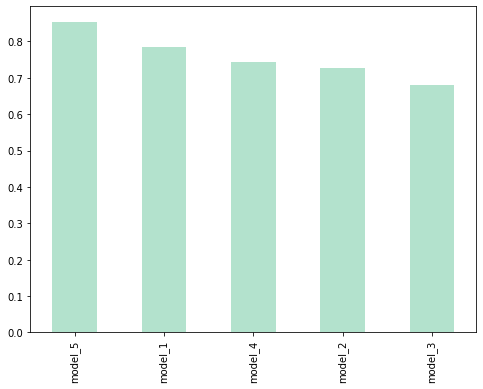

In [ ]:
all_results_df['f1'].sort_values(ascending=False).plot(kind='bar',cmap='Pastel2',figsize=(8,6),alpha=1)

# Save and Load the Best Model

In [ ]:
#Save the char_token_pos tribrid model
model_5.save('saved_models/skimlit_tribrid_model')

INFO:tensorflow:Assets written to: saved_models/skimlit_tribrid_model/assets


INFO:tensorflow:Assets written to: saved_models/skimlit_tribrid_model/assets


In [ ]:
#Save model to GoogleDrive
!cp './saved_models/skimlit_tribrid_model' -r '/content/drive/MyDrive/tensorflow_course/saved_models'

In [ ]:
#Loade the saved Model
loaded_model = tf.keras.models.load_model('/content/drive/MyDrive/tensorflow_course/saved_models/skimlit_tribrid_model')

In [ ]:
y_pred_probs_val = loaded_model.predict(valid_dataset)
y_pred_val = tf.argmax(y_pred_probs_val,axis=1)
y_pred_val

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [ ]:
loaded_model_results = evaluate(y_valid_encoded,y_pred_val)
loaded_model_results

{'accuracy': 0.8563484708063022,
 'f1': 0.8535480521232753,
 'precison': 0.8610561406679387,
 'recall': 0.8563484708063022}

# Evalate the model on test Dataset

## Create the dataset as required by the model


In [ ]:
#Get the Feature columns
test_text = test_df['text']
test_line_order = test_df['order']
test_total_lines = test_df['total_lines']
test_char_seq = [split_text(text) for text in test_text]
test_labels = test_df['target']

In [ ]:
#one_hot encode `line_order`
test_line_order_one_hot = tf.one_hot(test_line_order,depth=max_line_order_depth)
#one_hot encode `total_lines`
test_total_lines_one_hot = tf.one_hot(test_total_lines,depth=max_total_lines_depth)
# one_hot encode target labels
test_labels_one_hot = one_hot.transform(test_labels.to_numpy().reshape(-1,1))
# encode test_labels
test_labels_encoded = label_encoder.transform(test_labels)

array([0, 4, 4, ..., 4, 4, 1])

In [ ]:
#create batched dataset
X_test = Dataset.from_tensor_slices((test_text,test_char_seq,test_line_order_one_hot,test_total_lines_one_hot))
y_test = Dataset.from_tensor_slices(test_labels_one_hot)
test_dataset = Dataset.zip((X_test,y_test)).batch(32).prefetch(AUTOTUNE)
test_dataset

<PrefetchDataset shapes: (((None,), (None,), (None, 17), (None, 22)), (None, 5)), types: ((tf.string, tf.string, tf.float32, tf.float32), tf.float64)>

In [ ]:
y_pred_probs_test = loaded_model.predict(test_dataset)

<tf.Tensor: shape=(5,), dtype=int64, numpy=array([15842,   612, 10635, 27116,  7923])>

In [ ]:
y_pred_test = tf.argmax(y_pred_probs_test,axis=1)
y_pred_test

<tf.Tensor: shape=(30135,), dtype=int64, numpy=array([3, 0, 2, ..., 4, 4, 2])>

In [ ]:
test_results = evaluate(test_labels_encoded,y_pred_test)
test_results

{'accuracy': 0.8476522316243571,
 'f1': 0.8447394834107151,
 'precison': 0.8516819160675403,
 'recall': 0.8476522316243571}

In [ ]:
y_pred_labels = class_names[y_pred_test]
y_pred_labels

array(['OBJECTIVE', 'BACKGROUND', 'METHODS', ..., 'RESULTS', 'RESULTS',
       'METHODS'], dtype=object)

In [ ]:
test_df['pred_label'] = y_pred_labels
test_df['pred_prob'] = np.max(y_pred_probs_test,axis=1)
test_df.head()

,order,text,target,total_lines,pred_label,pred_prob
0,0,This study analyzed liver function abnormaliti...,BACKGROUND,9,OBJECTIVE,0.484802
1,1,A post hoc analysis was conducted with the use...,RESULTS,9,BACKGROUND,0.413142
2,2,Liver function tests ( LFTs ) were measured at...,RESULTS,9,METHODS,0.849780
3,3,Survival analyses were used to assess the asso...,RESULTS,9,METHODS,0.740671
4,4,The percentage of patients with abnormal LFTs ...,RESULTS,9,RESULTS,0.754065


In [ ]:
sorted_test_df = test_df.sort_values('pred_prob',ascending=False)

In [ ]:
false_pred_df = sorted_test_df[test_df.target!=test_df.pred_label]
true_pred_df = sorted_test_df[test_df.target==test_df.pred_label]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [ ]:
false_pred_df.shape
false_pred_df.head()

,order,text,target,total_lines,pred_label,pred_prob
20040,11,Chictr.org .,CONCLUSIONS,13,BACKGROUND,0.918486
18720,8,non-diffuse-trickling '' ) .,RESULTS,16,BACKGROUND,0.907433
835,0,To assess the temporal patterns of late gastro...,BACKGROUND,12,OBJECTIVE,0.904320
18191,5,SE game clinicians were e-mailed @ question ev...,RESULTS,18,METHODS,0.899832
10452,0,To validate the association between accommodat...,BACKGROUND,11,OBJECTIVE,0.899107


In [ ]:
for row in false_pred_df[:10].itertuples():
  _,order, text, target, total_lines, pred_label, pred_prob = row
  print(f'''Target: {target}\tPred: {pred_label}\tPred Prob: {pred_prob:.2f}
        Text:\t{text}
        Line_order: {order}\tTotal_lines: {total_lines}\n''')

Target: CONCLUSIONS	Pred: BACKGROUND	Pred Prob: 0.92
        Text:	Chictr.org .
        Line_order: 11	Total_lines: 13

Target: RESULTS	Pred: BACKGROUND	Pred Prob: 0.91
        Text:	non-diffuse-trickling '' ) .
        Line_order: 8	Total_lines: 16

Target: BACKGROUND	Pred: OBJECTIVE	Pred Prob: 0.90
        Text:	To assess the temporal patterns of late gastrointestinal ( GI ) and genitourinary ( GU ) radiotherapy toxicity and resolution rates in a randomised controlled trial ( All-Ireland Cooperative Oncology Research Group @-@ ) assessing duration of neo-adjuvant ( NA ) hormone therapy for localised prostate cancer .
        Line_order: 0	Total_lines: 12

Target: RESULTS	Pred: METHODS	Pred Prob: 0.90
        Text:	SE game clinicians were e-mailed @ question every @ days .
        Line_order: 5	Total_lines: 18

Target: BACKGROUND	Pred: OBJECTIVE	Pred Prob: 0.90
        Text:	To validate the association between accommodation and visual asthenopia by measuring objective accommodative am